# Extending codes to support Vector Autoregressive models

In [1]:
import xarray as xr

import numpy as np
from numpy.lib.stride_tricks import sliding_window_view

import pandas as pd

from src import utils

import matplotlib.pyplot as plt

from src import ar_model

from statsmodels.tsa.api import VAR
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.ar_model import AutoReg, ar_select_order

In [7]:
plt.rcParams["figure.figsize"] = (14, 6)
plt.rcParams["font.size"] = 12

In [3]:
%load_ext autoreload
%autoreload 2
%load_ext lab_black

In [4]:
DATA_DIR = "../../data/processed"

# Let's just fit to observations for now, though a fit to historical model runs may be more appropriate

In [5]:
HadISST = xr.open_zarr(f"{DATA_DIR}/tos_HadISST.zarr", use_cftime=True)
AMV = (
    utils.calculate_period_AMV_index(
        HadISST["sst"],
        [12, 1, 2, 3],
    )
    .rename("AMV")
    .compute()
)
AMV = utils.round_to_start_of_month(AMV, dim="time")

HadSLP = xr.open_zarr(f"{DATA_DIR}/psl_HadSLP2r.zarr", use_cftime=True)
NAO = (
    utils.calculate_period_NAO_index(
        HadSLP["slp"],
        [12, 1, 2, 3],
    )
    .rename("NAO")
    .compute()
)

AMV, NAO = xr.align(AMV, NAO)

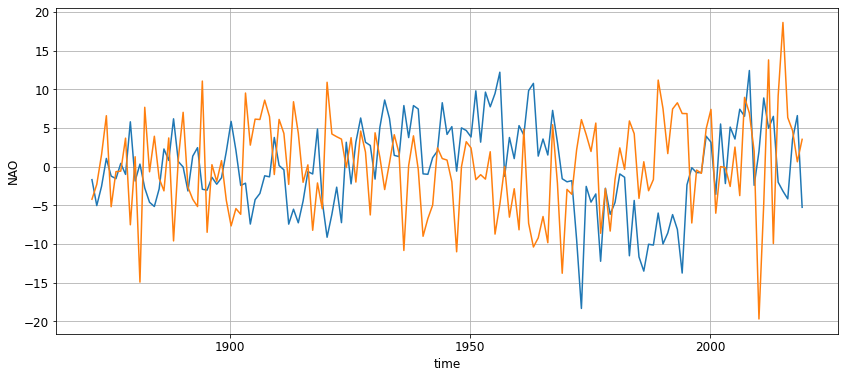

In [8]:
(40 * AMV).plot(label="AMV")
NAO.plot(label="NAO")
plt.grid()

# Fit a VAR model

In [9]:
input_data = pd.concat(
    (AMV.to_dataframe(), NAO.to_dataframe()),
    axis=1,
)

## Check that input series are stationary

In [10]:
signif = 0.05

for var in input_data.columns:
    res = adfuller(input_data[var])
    if res[1] < signif:
        print(f"{var} is stationary")
    else:
        print(f"{var} is non-stationary")

AMV is stationary
NAO is stationary


## As a check, do the fit myself and compare to `statsmodels`

In [11]:
order = 2

In [12]:
def my_OLS_fit(predictor, response):
    XtX = np.matmul(predictor.T, predictor)
    XtY = np.matmul(predictor.T, response)
    XtX_Inv = np.linalg.inv(XtX)

    b = np.matmul(XtX_Inv, XtY)

    return b

In [13]:
# Lag order with this approach is [y1_lag2, y1_lag1, y2_lag2, y2_lag1]
predictor = sliding_window_view(input_data.to_numpy(), window_shape=order, axis=0)
predictor = predictor.reshape((predictor.shape[0], -1))[:-1, :]

response = input_data.to_numpy()[order:]

my_params = pd.DataFrame(
    my_OLS_fit(predictor, response),
    index=["L2.AMV", "L1.AMV", "L2.NAO", "L1.NAO"],
    columns=["AMV", "NAO"],
)
my_params

,AMV,NAO
L2.AMV,0.258294,-9.742450
L1.AMV,0.435933,-1.676509
L2.NAO,0.000539,-0.012159
L1.NAO,-0.000936,0.062240


In [14]:
their_params = VAR(input_data).fit(order, trend="n").params
their_params

/g/data/xv83/users/ds0092/software/miniconda3/envs/squire_2022_correlation/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


,AMV,NAO
L1.AMV,0.435933,-1.676509
L1.NAO,-0.000936,0.062240
L2.AMV,0.258294,-9.742450
L2.NAO,0.000539,-0.012159


## Check that `res.sigma2` returned by `statsmodels` is just the variance of the residuals

In [15]:
from statsmodels.tsa.ar_model import AutoReg

res = AutoReg(input_data.to_numpy()[:, 0], lags=2, trend="n").fit()

print(f"Square root of res.sigma2: {np.sqrt(res.sigma2)}")
print(f"Standard deviation of residuals: {np.std(res.resid)}")

Square root of res.sigma2: 0.10972550897069779
Standard deviation of residuals: 0.10972513235786074


## Check that generate_samples matches `statsmodels.tsa.vector_ar.var_model.VARProcess`
Note, `generate_samples` below was run with `simulate_var(..., seed=0)` hardcoded internally

In [16]:
AMV_input = AMV.to_dataset()
NAO_input = NAO.to_dataset()

VAR_input = xr.merge((AMV_input, NAO_input))

In [17]:
order = 2
n_times = 50

res = VAR(VAR_input.to_dataframe()).fit(order, trend="n")

/g/data/xv83/users/ds0092/software/miniconda3/envs/squire_2022_correlation/lib/python3.10/site-packages/statsmodels/tsa/base/tsa_model.py:471: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


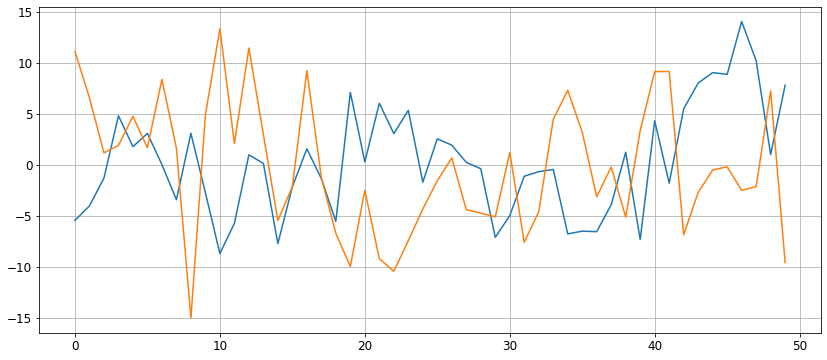

In [18]:
a = res.simulate_var(n_times + order, seed=0)[order:]

plt.plot(40 * a[:, 0])
plt.plot(a[:, 1])
plt.grid()

In [19]:
VAR_params = ar_model.fit(VAR_input, n_lags=order)

b = ar_model.generate_samples(VAR_params, n_times=n_times, n_samples=1)

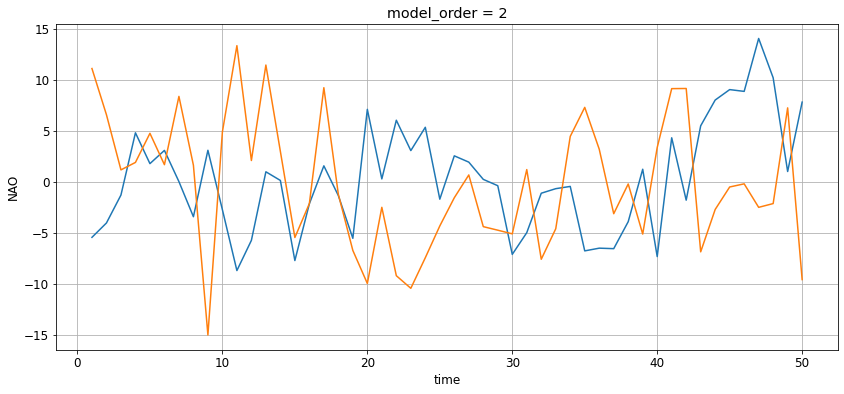

In [20]:
(40 * b["AMV"]).plot()
b["NAO"].plot()
plt.grid()

## Check that predictions match `statsmodels` method

#### VAR model

In [21]:
order = 4
n_steps = 10

In [22]:
VAR_params = ar_model.fit(VAR_input, n_lags=order)

inits = ar_model.generate_samples(VAR_params, n_times=100, n_samples=1)

VAR_params = xr.concat(
    (
        VAR_params.isel(params=slice(-2)),
        VAR_params - VAR_params.isel(params=slice(-2, None)),
    ),
    dim="params",
)

In [23]:
my_forecasts = ar_model.predict(VAR_params, inits, n_steps=n_steps).squeeze()

res = VAR(VAR_input.to_stacked_array(new_dim="var", sample_dims=["time"]).values).fit(
    order, trend="n"
)

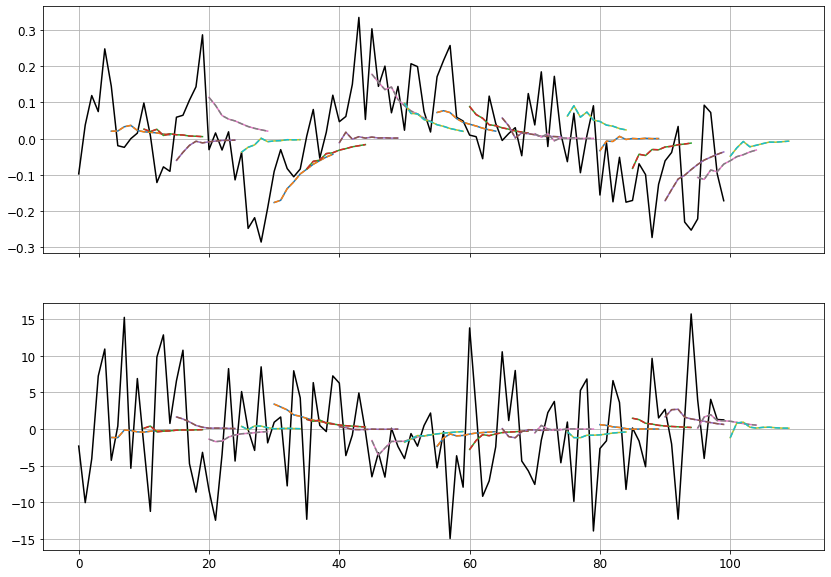

In [24]:
fig = plt.figure(figsize=(14, 10))
axs = fig.subplots(2, 1, sharex=True)

axs[0].plot(inits["AMV"], color="k")
axs[1].plot(inits["NAO"], color="k")

for init in my_forecasts.init.values[::5]:
    my_forecast = my_forecasts.sel(init=init)

    lead = my_forecast.lead + init
    axs[0].plot(lead, my_forecast["AMV"])
    axs[1].plot(lead, my_forecast["NAO"])

    their_forecast = res.forecast(
        inits.to_stacked_array(new_dim="var", sample_dims=["time"]).values[:init],
        n_steps,
    )
    axs[0].plot(lead, their_forecast[:, 0], linestyle="--")
    axs[1].plot(lead, their_forecast[:, 1], linestyle="--")

axs[0].grid()
axs[1].grid()

#### AR model

In [25]:
order = 2
n_steps = 10

In [26]:
AR_params = ar_model.fit(AMV_input, n_lags=order)

inits = ar_model.generate_samples(AR_params, n_times=100, n_samples=1)

# Refit to inits so that can use AutoReg predict function
AR_params = ar_model.fit(inits, n_lags=order)

AR_params = xr.concat(
    (
        AR_params.isel(params=slice(-1)),
        AR_params - AR_params.isel(params=slice(-1, None)),
    ),
    dim="params",
)

In [27]:
my_forecasts = ar_model.predict(AR_params, inits, n_steps=n_steps).squeeze()

res = AutoReg(inits["AMV"].values, lags=order, trend="n").fit()

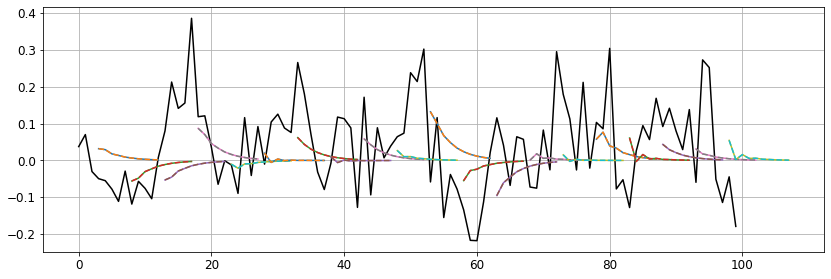

In [28]:
fig = plt.figure(figsize=(14, 4.5))
ax = fig.subplots(1, 1)

ax.plot(inits["AMV"], color="k")

for init in my_forecasts.init.values[::5]:
    my_forecast = my_forecasts.sel(init=init)

    lead = my_forecast.lead + init
    ax.plot(lead, my_forecast["AMV"])

    their_forecast = res.predict(init, init + n_steps - 1, dynamic=True)
    ax.plot(lead, their_forecast, linestyle="--")

ax.grid()

## Test `generate_samples_like` function, including diagnostic plots

In [ ]:
test = ar_model.generate_samples_like(
    VAR_input,
    n_lags=2,
    n_times=45,
    n_samples=3,
    n_members=20,
    rolling_means=[8],
    plot_diagnostics=True,
)